In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from tqdm import tqdm

CODE TO GENERATE LOOKUP TABLES

In [2]:
def newton_raphson_solver(f, x_0, max_iterations = 100, dx = 1e-3, return_error=False, tolerance = 1e-2, debug_mode=False):
    # Returns a zero of f given initial condition (x_0,f(x_0)). Modified from standard techniques to fail more gracefully in certain edge cases.
    x_n = x_0
    for i in range(max_iterations):
        f_prime_n = (f(x_n+dx)-f(x_n))/dx
        if f_prime_n == 0:
            raise ZeroDivisionError
        x_n = x_n - f(x_n)/f_prime_n
        if debug_mode: print(f(x_n))
    return_error = np.abs(f(x_n)) > tolerance 
    if return_error:
        raise ValueError(x_n, f(x_n))
    return x_n

k_B = 1 # Special units
T_b = 1 # Special units


x_well = 0.5 # Special units
E_barrier = 2*k_B*T_b # J
E_tilt = 1.3*k_B*T_b # J
F_max = 50 # Special Units

F_left = 1.0*F_max
F_right = 1.0*F_max

# asymmetry = 1 # |x_max/x_min|
x_min = -2*x_well # Always negative by convention.
x_max = 9*(-x_min) #np.abs(asymmetry*x_min)

temperature = {'h': 1000,
'w': 12,
'c': 1
}

D = 50 # px^2/s
gamma = k_B*T_b/D #0.02

char_time = (x_max-x_min)*gamma/F_max # s (hopefully): Time required to cover the entire domain moving at the maximum velocity, F_max/gamma
expt_length = 0.1 # s
dt = 1e-5 # s

def U_0(x):
    return E_barrier*(1-2*(x/x_well)**2 + (x/x_well)**4) - E_tilt*(x/x_well)/2
def dU_0dx(x):
    return E_barrier*(-4*x/x_well**2 + 4*x**3/x_well**4) - E_tilt/(2*x_well)

# E_strength = 1*k_B*T_b
n = 1
x_s = 2.0
E_shelf = 5*k_B*T_b
def U_w0(E_0, x):
    return E_0*(x/x_well)**(2*n+1) + E_shelf*(x/x_well)
def dU_w0dx(E_0, x):
    return (2*n+1)*(E_0/x_well)*(x/x_well)**(2*n) + E_shelf/x_well

W = False
B = False and not W
test_mode = False and not (B or W)
flat = False and not (test_mode or B or W)

try:
    x_l = newton_raphson_solver(lambda x: dU_0dx(x) + F_max, x_min, dx=1e-6)
    x_r = newton_raphson_solver(lambda x: dU_0dx(x) - F_max, x_max, dx=1e-6)
    # x_d = newton_raphson_solver(lambda x: dU_bdx(x) + F_max, x_max, dx=1e-6)
    # x_d = newton_raphson_solver(lambda x: dU_bdx(x) + F_left, x_max, dx=1e-6)
    if B:
        x_d = -(x_well**2)*F_max/(2*E_strength)
        x_s = -(x_well**2)*F_left/(2*E_strength)
        # E_strength = newton_raphson_solver(lambda E: dU_b0dx(E, -x_s)-F_max, x_0=energy_ratio)
    if W:
        E_strength = newton_raphson_solver(lambda E: dU_w0dx(E, -x_s)-F_max, x_0=E_shelf)
        U_w = lambda x: U_w0(E_strength, x)
        x_d = newton_raphson_solver(lambda x: dU_w0dx(E_strength, x)-F_right, x_0=x_s)

    def U_b(x):
        return -E_strength*(x/x_well)**2

    y = sym.symbols("y")
    dU_0dx = sym.lambdify(y, sym.diff(U_0(y), y))
    if W: dU_wdx = sym.lambdify(y, sym.diff(U_w(y), y))
    if B: dU_bdx = sym.lambdify(y, sym.diff(U_b(y), y))

except ZeroDivisionError:
     print("Zero slope potential; setting x_l=x_min and x_r=x_max")
     x_l = x_min
     x_r = x_max # Makes it so that the code still works for flat potentials. This is a possible source of error if the code has a lot of opints of inflection: check that x_min and x_max are not maxima/minima.


def U(x, x_l=x_l, x_r=x_r, W=W, B=B, test_mode = test_mode):
#     if x > x_l and x < x_r:
#         return U_0(x)
#     else:
#         if x < x_l:
#             return U_0(x)-F_max*x
#         else:
#             return U_0(x)+F_max*x
    in_well = (x >= x_l) & (x <= x_r)
    left_of_well = (x < x_l)
    right_of_well = (x > x_r)
    # Boolean arrays to determine where the particle is relative to the 'walls'
    if B:
        return U_0(x)*in_well + (U_0(x_r) + F_left*(x-x_l))*left_of_well + (U_0(x_r) - U_b(-x_d) + U_b(x-x_r-x_d))*(right_of_well & (x < x_r+x_d-x_s)) + (U_0(x_r) - U_b(-x_d) + U_b(-x_s) + F_right*(x-x_d-x_s-x_r))*(x >= x_r+x_d+x_s)
    if W:
        return U_0(x)*in_well + (U_0(x_l) - F_left*(x-x_l))*left_of_well + (U_0(x_r) - U_w(-x_s) + U_w(x-x_r-x_s))*(right_of_well & (x < x_r+x_s+x_d)) + (U_0(x_r) - U_w(-x_s) + U_w(x_d) + F_right*(x-x_r-x_s-x_d))*(x >= x_r+x_d+x_s)
    if test_mode:
        return E_barrier*(x/x_well)**2
    if flat:
        if type(x) == float:
            return 0
        return np.zeros(x.shape)
    return U_0(x)*in_well + (U_0(x_l)-F_left*(x-x_l))*left_of_well + (U_0(x_r)+F_right*(x-x_r))*right_of_well

def F(x, x_l = x_l, x_r = x_r, W=W, B=B, test_mode=test_mode):
    in_well = (x >= x_l) & (x <= x_r)
    left_of_well = (x < x_l)
    right_of_well = (x > x_r)
    if B:
        return -dU_0dx(x)*in_well - F_right*right_of_well - dU_bdx(x-x_l-x_d)*(left_of_well & (x > x_l+x_d-x_s)) + F_left*(x <= x_l+x_d-x_s)
    if W:
        return -dU_0dx(x)*in_well + F_left*left_of_well - dU_wdx(x-x_r-x_s)*(right_of_well & (x < x_r+x_s+x_d)) - F_right*(x >= x_r+x_d+x_s)
    if test_mode:
        return -2*E_barrier*(x/x_well**2)
    if flat:
        if type(x) == float:
            return 0
        return np.zeros(x.shape)
    return -dU_0dx(x)*((x > x_l) & (x < x_r)) + F_left*(x<=x_l) - F_right*(x>=x_r)


x_arr = np.linspace(x_min, x_max, 512)

not exporting


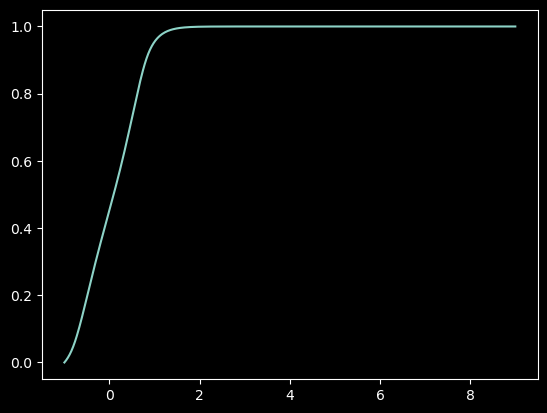

In [ ]:
from tqdm import tqdm

export = False # switch to false if you don't want to export
k_BT_h = 12
filename = f"T={k_BT_h}, alpha=9.txt"
# filename = f"T={k_BT_h}, alpha=9.txt"
p_unnormalised = lambda x0: np.exp(-U(x0)/(k_BT_h))
Z = scipy.integrate.quad(p_unnormalised, x_min, x_max)[0]
directory = f"../Lookup tables/E_tilt={E_tilt}/"

def PDF(x,k_BT):
    p_unnormalised = lambda x0: np.exp(-U(x0)/k_BT)
    Z = scipy.integrate.quad(p_unnormalised, x_min, x_max)[0]
    return p_unnormalised(x)/Z

def CDF(x, k_BT, x_min=x_min):
    p_unnormalised = lambda x0: np.exp(-U(x0)/k_BT)
    Z = scipy.integrate.quad(p_unnormalised, x_min, x_max)[0]
    integrator = np.vectorize(lambda upper_bound: min(1, scipy.integrate.quad(lambda y: p_unnormalised(y)/Z, x_min, upper_bound, 
                                                                                epsabs=1.49e-14, epsrel=1.49e-14)[0])) # epsrel and epsabs required to avoid weirdness 
    return integrator(x)

def test_CDF(x):
    # Should generate uniform distro
    return (x-x_min)/(x_max-x_min)

y_arr = CDF(x_arr, k_BT_h)
# y_arr = []
# for x in tqdm(x_arr):
#     y_arr.append(CDF(x, k_BT_h, Z_known=Z))
plt.plot(x_arr, y_arr)

to_export = np.array(y_arr)
if export:
    np.savetxt(directory+filename, to_export, header = "Pr_INT\n", fmt="%.9f", comments='')
else: print("not exporting")

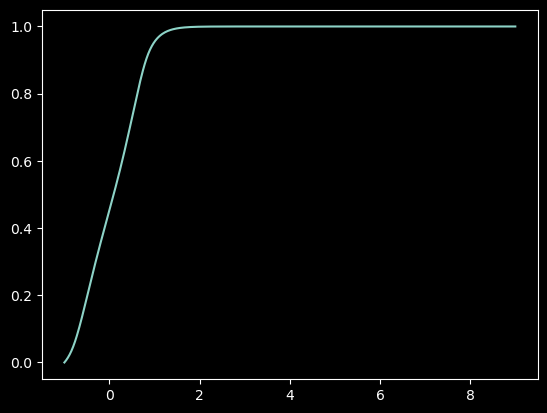

In [5]:
plt.plot(x_arr, CDF(x_arr, 12))#, temperature['h']))

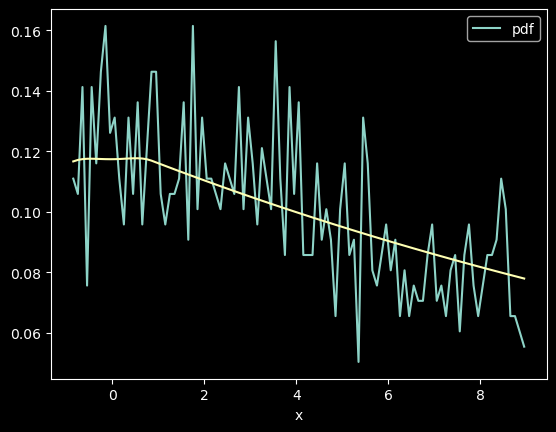

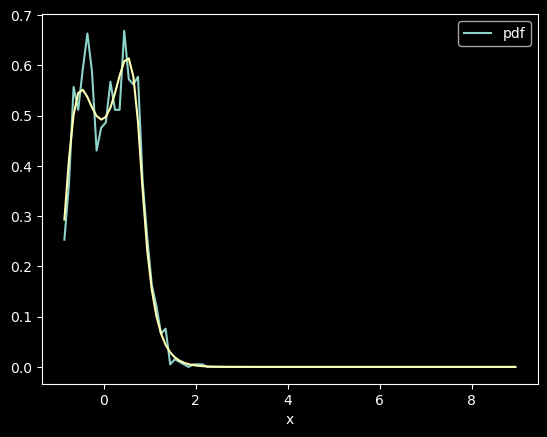

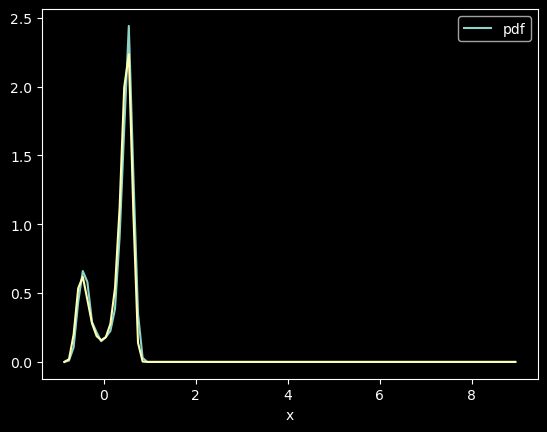

In [61]:
test_folder = "../Lookup tables/E_tilt=1.3/"

filenames = {T: f'test_{T}.lvm' for T in temperature}

test_pdf_df = {T: pd.read_table(test_folder+filenames[T], names=['x', 'hist', 'something'], header=22, usecols=[0,1]) for T in temperature}
for T in temperature:
    dx = test_pdf_df[T]['x'].iloc[1]-test_pdf_df[T]['x'].iloc[0]
    test_pdf_df[T]['pdf'] = test_pdf_df[T]['hist']/(dx*np.sum(test_pdf_df[T]['hist']))
for T in temperature:
    test_pdf_df[T].plot(x='x', y='pdf')
    plt.plot(test_pdf_df[T]['x'], PDF(test_pdf_df[T]['x'], temperature[T]))

In [6]:
def check_sorted(array):
    sorted_array = np.sort(array)
    return (array == sorted_array).all()

In [68]:
# INVERSION TRANSFORM SAMPLING WITH LINEAR INTERPOLATION: TESTS

lookup_tables = []
for filename in ["../Lookup tables/E_tilt=1.3/T="+name+", alpha=9.txt" for name in ['1', '12', '1000']]:
    lookup_tables.append(np.array(pd.read_table(filename)).flatten())
for table in lookup_tables:
    if not check_sorted(table): print('FAILURE')
lookup_tables[0]

array([0.00000000e+00, 6.00000000e-09, 2.10000000e-08, 6.20000000e-08,
       1.72000000e-07, 4.64000000e-07, 1.23900000e-06, 3.30300000e-06,
       8.79200000e-06, 2.32700000e-05, 5.90230000e-05, 1.40188000e-04,
       3.10319000e-04, 6.41048000e-04, 1.23989400e-03, 2.25414000e-03,
       3.86752900e-03, 6.28767300e-03, 9.72436900e-03, 1.43618650e-02,
       2.03303850e-02, 2.76830010e-02, 3.63828930e-02, 4.63035420e-02,
       5.72413660e-02, 6.89376960e-02, 8.11054880e-02, 9.34560220e-02,
       1.05721717e-01, 1.17672705e-01, 1.29126407e-01, 1.39950598e-01,
       1.50061305e-01, 1.59417194e-01, 1.68012053e-01, 1.75866706e-01,
       1.83021312e-01, 1.89528635e-01, 1.95448556e-01, 2.00843869e-01,
       2.05777267e-01, 2.10309343e-01, 2.14497413e-01, 2.18394962e-01,
       2.22051552e-01, 2.25513061e-01, 2.28822141e-01, 2.32018839e-01,
       2.35141307e-01, 2.38226613e-01, 2.41311606e-01, 2.44433865e-01,
       2.47632734e-01, 2.50950468e-01, 2.54433519e-01, 2.58133998e-01,
      

In [69]:
def find_le_index(sorted_list, number):
    if type(number) != float: number = np.array(number).reshape(len(number), 1)
    arr = np.array(sorted_list)
    arr_shift = arr[1:]
    # print(((arr[:-1] <= number) & (arr_shift >= number)).T)
    indices = np.where((arr[:-1] <= number) & (arr_shift >= number))[-1]
    return indices

sample_pdf = lookup_tables[0]
index = find_le_index(sample_pdf, [0.9999999, 0.4])
# print("Index:", index, sample_pdf[index])
index

array([101,  69], dtype=int64)

array([82.92051498, 83.04225198, 78.13701937, ..., 44.20398356,
       73.01286873, 70.85143482])

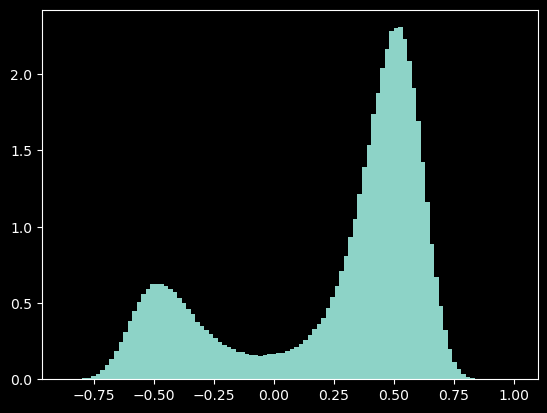

In [70]:
def lint(pdf, num_samples):
    u = np.random.random(size=num_samples)
    lower = find_le_index(pdf, u)
    upper = lower + 1
    u2 = np.random.random(size=num_samples)
    return (upper-lower)*u2+lower

# lint(lookup_tables[0], 1)
# find_le_index(lookup_tables[0])
pdf = lookup_tables[0]
inversion_transform_indices = lint(pdf, 1_000_000)
x_vals = 10*(inversion_transform_indices/512)-1 # Adjust indices to be a number between (-1,9)
plt.hist(x_vals, bins=100, density=True)
# np.linspace(-1,9, pdf.shape[0])
inversion_transform_indices

In [3]:
directory = "./2025_04_24/"

column_names = ['x','t', 'V', 'F']

df_h = pd.read_table(directory+"data_h.txt", names=column_names)
df_w = pd.read_table(directory+"data_w.txt", names=column_names)
df_c = pd.read_table(directory+"data_c.txt", names=column_names)
# df_w.memory_usage()

In [ ]:
def in_range(x, y, epsilon):
    # checks if y-ε < x < y+ε
    return (x > y-epsilon) & (x < y+epsilon)

def chunk_splitter(dataframe):
    # Takes in a pandas dataframe with a t column and splits it into a bunch
    # of little dataframes with linearly increasing t. Will ignore first and last cycles 
    pivots = dataframe[dataframe['t']==0].index
    chunks = []
    for i in range(len(pivots)-1):
        chunks.append(dataframe.iloc[pivots[i]:pivots[i+1]])
    return np.array(chunks) # Shape of np.array(chunks) will be (number of particles, timesteps, number of datatypes) = (N, expt_length, #datatypes)

def pack_data(chunks):
    # Packs properly split data into a series of histograms
    pass # TODO

chunks_h = chunk_splitter(df_h)
chunks_c = chunk_splitter(df_c)
chunks_w = chunk_splitter(df_w)

particles_h = np.array(chunks_h)
particles_c = np.array(chunks_c)
particles_w = np.array(chunks_w)
# chunks_h[1]

In [5]:
# np.roll(chunks_h[i]['t'], 1)[-1:]
# arr1 = np.array(chunks_h[i]['t'])[1:]
# arr2 = np.array(chunks_h[i]['t'])[:-1]
# arr2-arr1
# # chunks_h[i]['t'][1:] - chunks_h[i]['t'][:-1]

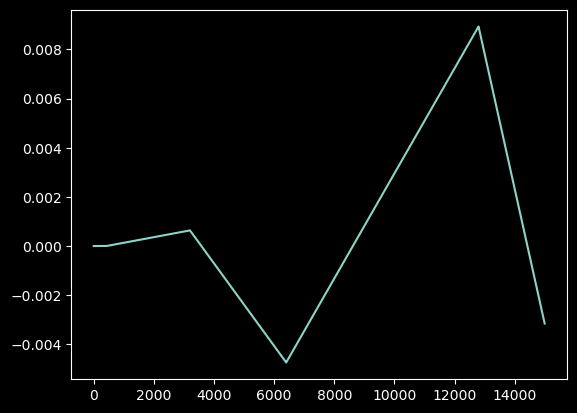

In [13]:
%matplotlib inline
plt.close()
i = np.random.choice(range(particles_h.shape[0]))
arr1 = np.array(chunks_h[i]['t'])[1:]
arr2 = np.array(chunks_h[i]['t'])[:-1]
# plt.plot(range(15000), arr2-arr1)
plt.plot(range(15000), arr2-0.01*np.array(range(15000)))

# plt.plot([3201,3201], [-0.005,0.01])
# plt.plot([6401,6401], [-0.005,0.01])
# plt.plot([9601,9601], [-0.005,0.01])
# plt.plot([12800,12800], [-0.005,0.01])
plt.show()
# df_h.iloc[:100000].plot(y="t")

(1999, 15001, 4)


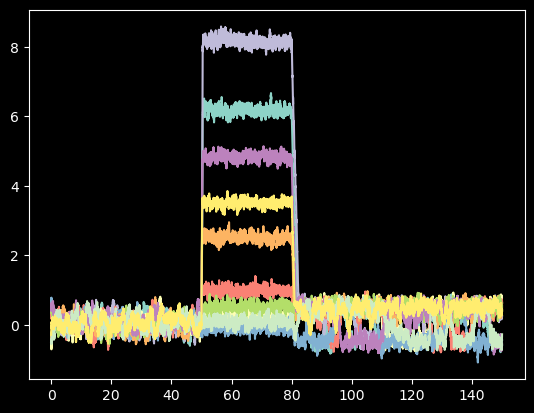

In [14]:
print(particles_h.shape)
num_plots = 10
# plt.plot(particles_h[:num_plots,:,1].T, particles_h[:num_plots,:,0].T)
plt.plot(particles_h[1500:1500+num_plots,:,1].T, particles_h[:num_plots,:,0].T)
# initial_h = particles_h[particles_h[:,:,1]==80.008682]
# plt.hist(initial_h[:,0])
%matplotlib inline

(2.999154389555429, 27.01530254239715)

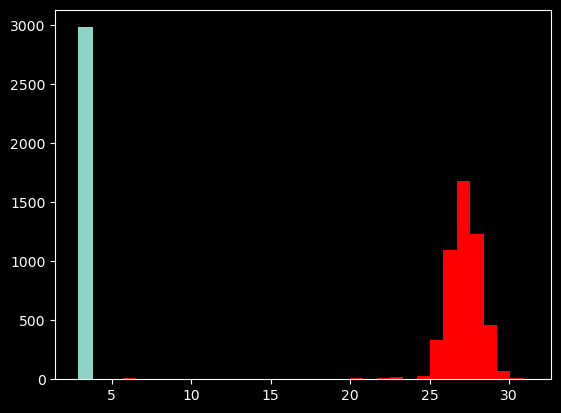

In [15]:
def find_trap_const(gaussian_data, k_BT=1):
    # data is assumed to be a particle in a harmonic well. Subtracts off the mean and finds the standard deviation
    sigma_vals = gaussian_data.std(axis=0) # Find the standard devation of X(t), <dX(t)>_t
    k = k_BT/sigma_vals**2 # std of particle in a trap is given by 2k_BT/k, and we set k_BT=1.
    return k

k_vals = find_trap_const(particles_w[:,5001:8001,0])
k_vals_hw = find_trap_const(particles_w[:,:5001,0])
plt.hist(k_vals, bins=30)
plt.hist(k_vals_hw, bins=30, color='r'),
k_vals.mean(), k_vals_hw.mean()

NameError: name 'x_arr' is not defined

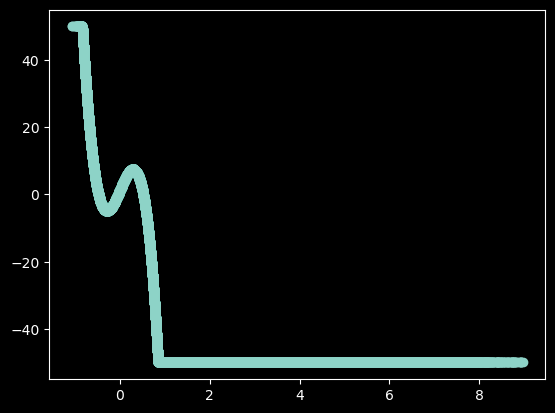

In [17]:
# Check whether force is calculated as expected

plt.scatter(particles_h[:,:,0][:100,8001:], particles_h[:,:,3][:100,8001:]) # Plot of x vs F. Should look like cubic with capped ends
plt.plot(x_arr, F(x_arr), 'g')

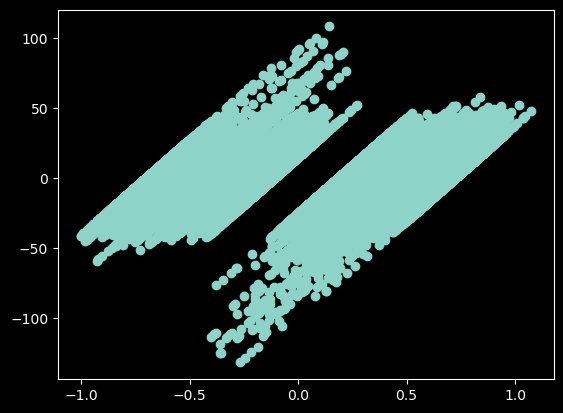

In [18]:
plt.scatter(particles_c[:,:,0][:100,5001:8000], particles_c[:,:,3][:100,5001:8000])

In [6]:
modified_particles_h = particles_h[:,:,:2][:].T
energies_h = U(modified_particles_h[0])
modified_particles_w = particles_w[:,:,:2][:].T
energies_w = U(modified_particles_w[0])
modified_particles_c = particles_c[:,:,:2][:].T
energies_c = U(modified_particles_c[0])
# U(modified_particles_h)
# U(particles_h).mean(axis=0)

In [10]:
n_release = 0
energies_h[n_release:].mean(axis=1), energies_c[n_release:].mean(axis=1)

(array([149.56077774, 149.74877747, 149.91372297, ...,   0.31990082,
          0.31419962,   0.30785928]),
 array([0.21060933, 0.2423722 , 0.26217014, ..., 0.20614374, 0.2136455 ,
        0.21429087]))

Text(0.5, 1.0, '$E_b=2.0k_BT$, $\\Delta E=1.3k_BT$, $N=1999$')

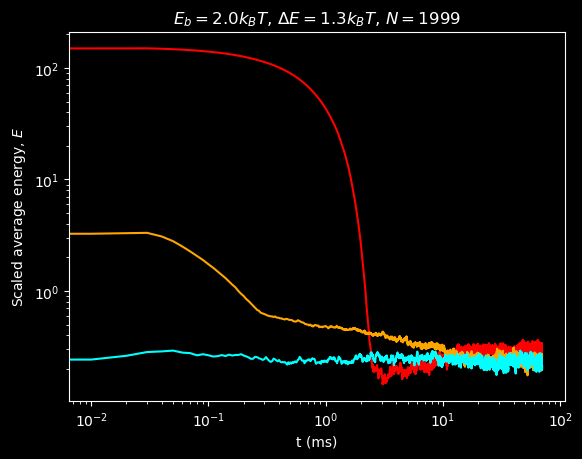

In [11]:
n_release = 0 # cycle at which point the particles are released

average_energy_floor_h = energies_h[n_release:].mean(axis=1)[-400:].mean(axis=0)
average_energy_floor_w = energies_w[n_release:].mean(axis=1)[-400:].mean(axis=0)
average_energy_floor_c = energies_c[n_release:].mean(axis=1)[-400:].mean(axis=0)
# print(average_energy_floor_h, average_energy_floor_w, average_energy_floor_c)

plt.loglog(particles_h[:,n_release:,1][0][:]-80,energies_h[n_release:].mean(axis=1)[:], 'r')
plt.loglog(particles_w[:,n_release:,1][0][:]-80,energies_w[n_release:].mean(axis=1)[:], 'orange')
plt.loglog(particles_c[:,n_release:,1][0][:]-80,energies_c[n_release:].mean(axis=1)[:], 'cyan')
# plt.plot([0,70], [1,1])
# output_energy_dataframe = pd.DataFrame(
#     np.array([particles_h[:,8000:,1][0][:]-80, 
#     energies_h[8000:].mean(axis=1)[:]/average_energy_floor_h,
#     energies_w[8000:].mean(axis=1)[:]/average_energy_floor_w,
#     energies_c[8000:].mean(axis=1)[:]/average_energy_floor_c
# ])).T.rename(columns={0: "t", 1: "E_h", 2: "E_w", 3: "E_c"})
plt.xlabel("t (ms)")
plt.ylabel(r"Scaled average energy, $E$")
plt.title(r"$E_b=2.0k_BT$, $\Delta E=1.3k_BT$, $N=1999$")
# plt.savefig("2025_01_29_averageEnergy.pdf")
# plt.loglog(particles_c[:,8000:,1][0][:]-80,energies_c[8000:].mean(axis=1)[:])

In [12]:
t = n_release
results = {
    'h': particles_h[:,t:,0],
    'w': particles_w[:,t:,0],
    'c': particles_c[:,t:,0]
}
temperature = {
    'h': 1000,
    'w': 12,
    'c': 1
}
unnormalised_boltzmann = lambda x, T: np.exp(-U(x)/(k_B*T))

In [14]:
BINS = 100

binned_active_domain = np.linspace(x_min, x_max, BINS)

global_min = np.min(results['h'])
global_max = np.max(results['h'])
inefficiencies = (global_max/x_max, global_min/x_min)
print(f"Inefficiency = {inefficiencies}")
inefficiency = (global_max-global_min)/(x_max-x_min)

if inefficiency > 1:
    binned_active_range0 = np.linspace(global_min, global_max, round(BINS*inefficiency)-1)
else:
    binned_active_range0 = np.linspace(global_min, global_max, BINS-1)

dx = binned_active_range0[1]-binned_active_range0[0]
binned_active_range0 += dx/2 # We must calculate distributions from the *centres* of the bins, not the edges!
binned_active_range = np.insert(binned_active_range0, 0, binned_active_range0[0]-dx)
boltzmann = lambda x,T: unnormalised_boltzmann(x,T)/scipy.integrate.quad(lambda y: unnormalised_boltzmann(y,T), x_min, x_max)[0]

if not (inefficiency > 100):
    unnormalised_distro_init = {T: unnormalised_boltzmann(binned_active_range, temperature[T]) for T in temperature}
    binned_initial_distro = {T: unnormalised_distro_init[T]/np.sum(unnormalised_distro_init[T]) for T in temperature}

    unnormalised_distro_fin = unnormalised_boltzmann(binned_active_range, T_b)
    binned_final_distro = unnormalised_distro_fin/np.sum(unnormalised_distro_fin)

    heights_init, bins_init = {}, {}
    heights_fin, bins_fin = {}, {}
    heights_mid, bins_mid = {}, {}
    heights_mid2 = {}

    for T in temperature:
        heights_init[T] = np.histogram(results[T][:,0], bins=binned_active_range)[0]
        heights_mid[T] = np.histogram(results[T][:,341], bins=binned_active_range)[0]
        heights_mid2[T] = np.histogram(results[T][:,382], bins=binned_active_range)[0]
        heights_fin[T] = np.histogram(results[T][:,-1], bins=binned_active_range)[0]
# plt.hist(results['h'].T[-1], bins='auto', density=True)
# plt.hist(results['h'].T[0])
# plt.plot(active_range, final_distro, 'w')

Inefficiency = (1.0522705555555556, 1.137945)


In [15]:
# T = 'c'
# k_trap = 7
# gaussian = lambda x: np.sqrt(k_trap/(2*k_B*np.pi*temperature[T]))*np.exp(-x**2/(2*k_B*temperature[T]/k_trap))
# plt.plot(test_arr, gaussian(test_arr))

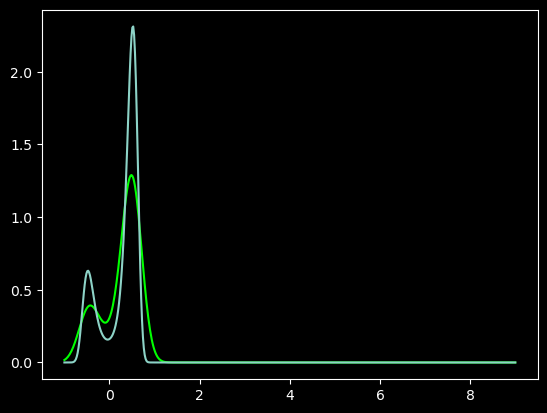

In [16]:
%matplotlib inline
Z = lambda T: scipy.integrate.quad(lambda y: unnormalised_boltzmann(y, T), x_min, x_max)
Z_arr = {T: Z(temperature[T])[0] for T in temperature}
k_trap = 29
gaussian = lambda x: np.sqrt(k_trap/(2*np.pi))*np.exp(-k_trap*x**2/2) # k_BT_c = 1
def p(x, T): 
        return (np.exp(-U(x)/(k_B*temperature[T]))/Z_arr[T])*((x > x_min) & (x < x_max))
def convolved_histogram(x, T, k_trap=k_trap, x_min=x_min, x_max=x_max, Z_arr=Z_arr):
    # temperature['c'] = 1 since the trap doesn't know what the set temperature is
    return scipy.integrate.quad(lambda z: p(z,T)*gaussian(z-x), -np.inf, np.inf)[0]

convolved_histogram = np.vectorize(convolved_histogram)

plt.plot(x_arr, convolved_histogram(x_arr, 'c'), 'lime')
plt.plot(x_arr, p(x_arr, 'c'))
# plt.plot(x_arr, gaussian(x_arr))
plt.show()

In [17]:
particles_c.shape

(2472, 7001, 4)

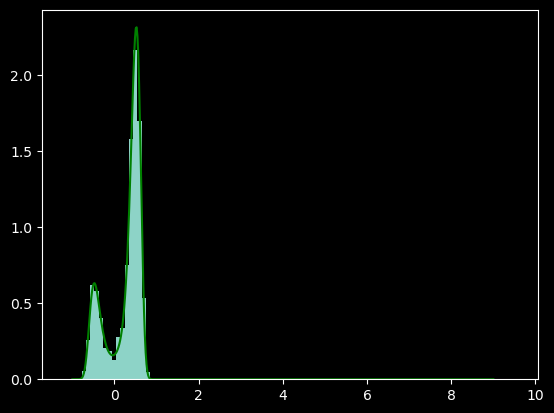

In [ ]:
initial_values_c = particles_c[:,5001:8001,0].mean(axis=1)
heights_c_I = np.histogram(initial_values_c, bins=binned_active_range)[0]
initial_values_w = particles_w[:,5001:8001,0].mean(axis=1)
heights_w_I = np.histogram(initial_values_w, bins=binned_active_range)[0]
initial_values_h = particles_h[:,5001:8001,0].mean(axis=1)
heights_h_I = np.histogram(initial_values_h, bins=binned_active_range)[0]

plt.bar(binned_active_range[1:]-dx/2, heights_c_I/(N*dx), width=dx)
plt.plot(x_arr, boltzmann(x_arr, temperature['c']), 'g')

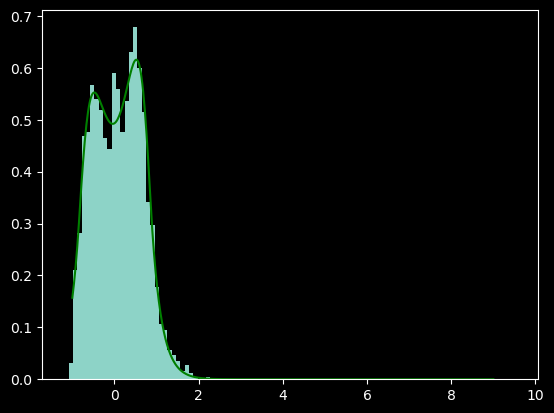

In [20]:
plt.bar(binned_active_range[1:]-dx/2, heights_w_I/(N*dx), width=dx)
plt.plot(x_arr, boltzmann(x_arr, temperature['w']), 'g')

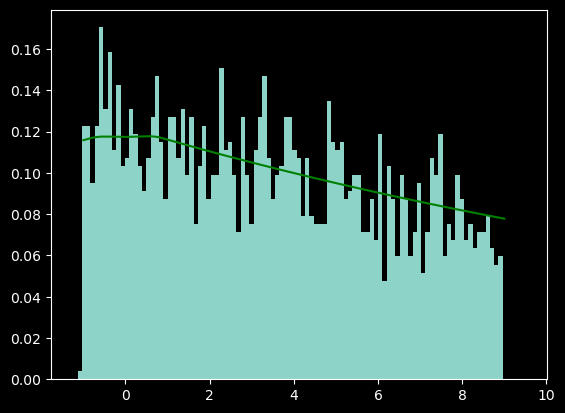

In [21]:
plt.bar(binned_active_range[1:]-dx, heights_h_I/(N*dx), width=dx)
plt.plot(x_arr, boltzmann(x_arr, temperature['h']), 'g')

In [22]:
smooth_bins

NameError: name 'smooth_bins' is not defined

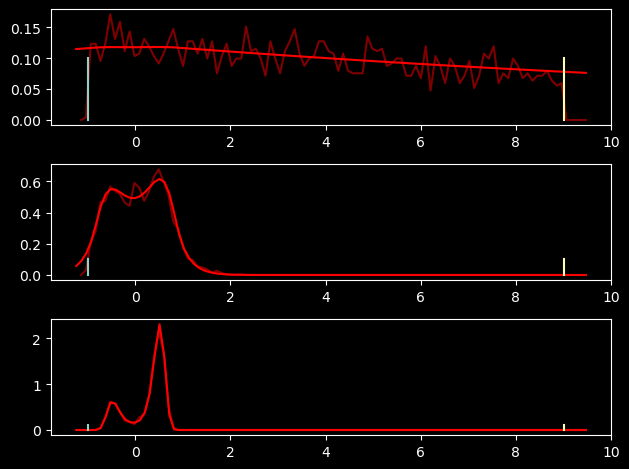

In [23]:
"""Sanity checks: The initial and final distributions should match the Boltzmann distro"""
plt.close()
temperature = {'h':1000, 'w': 12, 'c': 1}
fig, ax = plt.subplots(len(temperature))
vals = list(temperature.keys()) 

T_test = 2
test_binned_initial_distro = unnormalised_boltzmann(binned_active_range, T_test)/np.sum(unnormalised_boltzmann(binned_active_range, T_test))

plot_finals = False

N = particles_c.shape[0]
smooth_bins = np.linspace(binned_active_range[0], binned_active_range[-1], heights_init['c'].shape[0])-dx/2
for i in range(len(temperature)):
    # ax[i].bar(binned_active_range[1:]-dx/2, heights_init[vals[i]]/(N*dx), width=dx, alpha=0.5, color='r')
    ax[i].plot(binned_active_range[1:]-dx/2, heights_init[vals[i]]/(N*dx), alpha=0.5, color='r')
    # ax[i].plot(binned_active_range[1:]-dx/2, boltzmann(binned_active_range[1:]-dx/2, temperature[vals[i]]), 'orange')
    ax[i].plot(smooth_bins, boltzmann(smooth_bins,temperature[vals[i]]), 'r')
    # ax[i].plot(x_arr, convolved_histogram(x_arr,vals[i], k_trap=k_vals_hw.mean()), 'yellow')
    if plot_finals:
        ax[i].bar(binned_active_range[1:]-dx/2, heights_fin[vals[i]]/(N*dx), width=dx, alpha=0.5, color='lime')
        ax[i].plot(smooth_bins, boltzmann(smooth_bins,temperature['c']), 'lime')
    ax[i].plot([-1,-1],[0,0.1])
    ax[i].plot([9,9], [0,0.1])

plt.tight_layout()
# plt.plot([-1,-1], [0,0.15])
plt.show()

In [24]:
# boltzmann(smooth_bins,temperature['c']).sum()*(smooth_bins[1]-smooth_bins[0]), (heights_fin['c']/N).sum()
# plt.plot(smooth_bins, boltzmann(smooth_bins,temperature['c'])-heights_init[vals[i]]/(N*dx))
(boltzmann(smooth_bins,temperature['c'])-heights_init[vals[i]]/(N*dx)).sum()*dx

-0.009525285988714759

In [25]:
particles_c.shape

(2472, 7001, 4)

(105,)

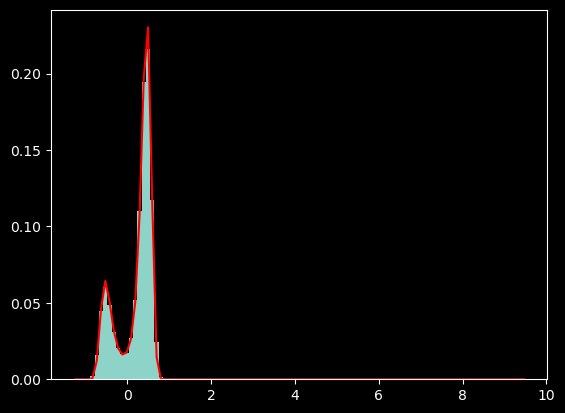

In [ ]:
def infer_final_distribution(bins, cold_distro, low_time=1000+8001, high_time=5000+8001):
    # Assumes cold distro has three cols, 'x', 't'
    cold_hist_data = cold_distro[:,low_time:high_time,0] # Take the time average over low_time:high_time to find the mean histogram
    heights = np.apply_along_axis(lambda x: np.histogram(x, bins=bins)[0], axis=0, arr=cold_hist_data)
    dx = bins[1]-bins[0]
    N = cold_distro.shape[0]
    return heights.mean(axis=1)/N

cold_distro = infer_final_distribution(binned_active_range-dx/2, particles_c, low_time=6000+8001, high_time=7000+8001)
plt.bar(binned_active_range[:-1]-dx/2, cold_distro,width=dx)
plt.plot(binned_active_range-dx/2, binned_final_distro, color='r')
# plt.hist(particles_c[:,9001:13001,0].mean() )
cold_distro.shape

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

Average noise in distance measurements (N=2472, N_b = 100) = 0.05513
Average noise amplitude in distance measurements (N=2472, N_b = 100) = 0.01203


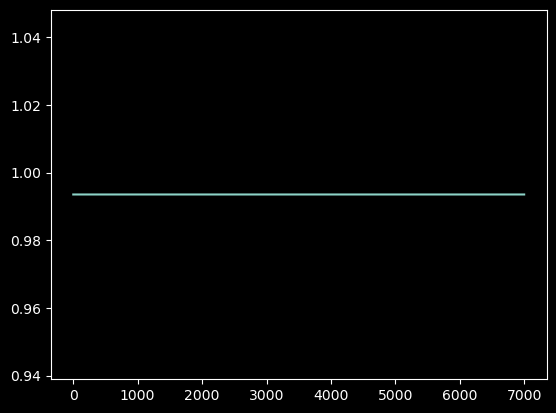

In [27]:
def L1(vec1, vec2, axis=None):
    assert len(vec1) == len(vec2), f"Mismatch between vec1 {np.array(vec1).shape} and vec2 {np.array(vec2).shape}"
    return np.sum(np.abs(vec2-vec1), axis=axis)

distances = {}
heights = {}
reshaped_final_distro = np.reshape(binned_final_distro[:-1],(len(binned_final_distro)-1,1)) 
# We reshape the final distro like this so we can vectorise the L1 distance: this turns it from a size=(n-1) array into a ((n-1),1) size array that you can subtract from a size ((n-1), number_of_timesteps) array without errors.
reshaped_cold_distro = np.reshape(cold_distro,(len(cold_distro),1)) # Reshaped inferred cold distribution
for T in tqdm(temperature):
    heights[T] = np.apply_along_axis(lambda x: np.histogram(x, bins=binned_active_range-dx/2)[0], axis=0, arr=results[T])
    distances[T] = L1(heights[T]/N, reshaped_cold_distro, axis=0)
    # Vectorised: about 2x faster than below unvectorised code.

    # Height, Bin = {}, {}
    # for i in tqdm(range(results[T].shape[1])):
    #     Height[T], Bin[T] = np.histogram(results[T][:,i], bins=binned_active_range)
    #     distances[T].append(L1(Height[T]/N, binned_final_distro[:-1]))
plt.close()
plt.plot((heights['h'].sum(axis=0))/N)
print(f"Average noise in distance measurements (N={N}, N_b = {BINS}) = {distances['c'].mean() :.5f}")
print(f"Average noise amplitude in distance measurements (N={N}, N_b = {BINS}) = {distances['c'].std() :.5f}")
plt.show()

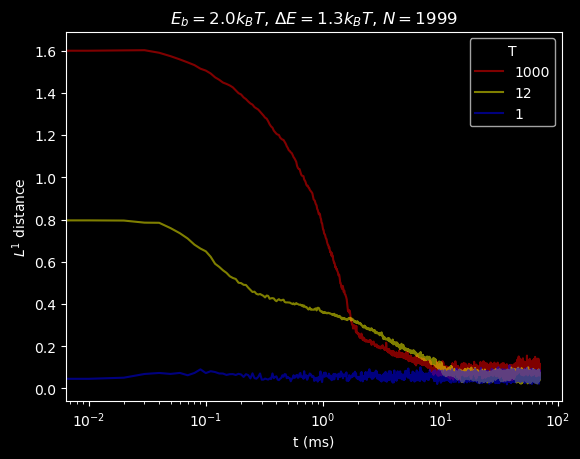

In [28]:
plt.close()
times = particles_h[:,:,1][0][n_release:]-80

def moving_average(noisy_data, window=10):
    # Smoothens noisy data. Larger window sizes will mean smoother data, at the cost of less resolution.
    length = len(noisy_data)
    outs = []
    for i in range(length):
        outs.append(np.average(noisy_data[max(i-window//2, 0): min(i+window//2, length)]))
    return outs

fig, ax = plt.subplots()
colours = {'h': 'red', 'w': 'yellow', 'c': 'blue', 'f': 'cyan'}
total_time = round(expt_length/dt) # iterations --- after this point there's only noise
start_time, end_time, window = 200, total_time, 200
tau=0
for T in temperature:
    ax.semilogx(times, distances[T], color = colours[T], alpha=0.5, label=temperature[T])
    # ax.loglog(range(start_time, end_time), distances[T][start_time:end_time], color = colours[T], alpha=0.3)
    # ax.loglog(times[start_time:end_time], moving_average(distances[T], window=window)[start_time:end_time], color = colours[T])
ax.legend(title="T")
plt.xlabel("t (ms)")
plt.ylabel(r"$L^1$ distance")
plt.title(r"$E_b=2.0k_BT$, $\Delta E=1.3k_BT$, $N=1999$")
# plt.title(f"τ: {tau/dt : .0f}Δt")
# plt.savefig("./2025_01_29_L1.pdf")
plt.show()
# export(fig, "./Corrected simulation data/ScriptW potential/Low temperature Mpemba effect", prefixes=f"τ = {tau/dt : .0f}Δt_") # Uncomment to save figure and parameter set

In [48]:
distances['c'][:-5000].mean(), distances['c'][:-5000].std(), distances['c'][:10].mean()

(0.073667008004002, 0.013489824086143094, 0.11432926463231614)

In [176]:
output_L1_dataframe = pd.DataFrame(np.array([distances['h'], distances['w'], distances['c']])).T.rename(columns={0:'L1_h', 1: 'L1_w', 2: 'L1_c'})

In [177]:
distances['c'][-1000:].mean()

0.062002970035742504

In [117]:
export = False
if export:
    output_energy_dataframe.to_csv("./average_energy.csv")
    output_L1_dataframe.to_csv("./L1.csv")

In [ ]:
# ANIMATION: UNCOMMENT THE LINES BELOW TO ANIMATE THE VIDEOS

# fig = plt.figure()
# ims = []
import matplotlib.animation as animation
from IPython.display import HTML
T = 'c'

new_binned_active_range = np.linspace(x_min, x_max, 200)
new_unnormalised_initial_distro = unnormalised_boltzmann(new_binned_active_range, temperature[T])
new_binned_initial_distro = new_unnormalised_initial_distro/np.sum(new_unnormalised_initial_distro)
new_unnormalised_final_distro = unnormalised_boltzmann(new_binned_active_range, temperature['c'])
new_binned_final_distro = new_unnormalised_final_distro/np.sum(new_unnormalised_final_distro)

expt_length = 7e-2
fig, ax = plt.subplots()
heights, bins = np.histogram(results[T][:,0], bins=new_binned_active_range)
patches = ax.bar(bins[:-1], heights/N, width=bins[1]-bins[0])
ax_height = np.max(new_binned_final_distro + 0.02)
ax.set_ylim(0,ax_height)
temperature_function= lambda t: (temperature[T]-T_b)*np.exp(-t/tau)+T_b

set_const_height = True
set_moving_height = False
plot_analytic_solution = False
expected_energy=0

# animated_frames = [i for i in range(20)] + [i for i in range(20,60, 2)] + [i for i in range(60,360, 5)] + [i for i in range(360,3960, 10)] + [i for i in range(3960,30000, 100)]
num_animated_frames = 1000 # Keep it small for efficient rendering
exponential_frame_func = lambda x, x_0: (expt_length/dt)*(np.exp(x/x_0)-1)/(np.exp(num_animated_frames/x_0)-1)
linear_frame_func = lambda x, x_0: (expt_length/dt)*x/x_0
animated_frames = np.rint(exponential_frame_func(np.arange(0,num_animated_frames, 1), 100)).astype('int')
# Time in the video will be on a log scale, primarily for rendering efficiency


def analytic_solution(x,t):
    unnormalised_soln = np.exp(-binned_active_range**2/(4*D*t))
    return unnormalised_soln/np.sum(unnormalised_soln)

ax.set_xlim((-1,3))
ax.set_xlabel("x")
ax.set_ylabel("p(x,t)")
ax.plot(new_binned_active_range, new_binned_initial_distro, 'r')
ax.plot(new_binned_active_range, new_binned_final_distro, 'g')
# Update function for the animation
def update(frame_number):
    # Get the data for the current frame
    # ax.clear()
    heights, bins = np.histogram(results[T][:,frame_number], bins=new_binned_active_range)    
    # Update the histogram data
    for i in range(len(patches)):
        patches[i].set_height(heights[i]/N)#, width=bins[1]-bins[0], color='y', alpha=0.7)
    ax.set_title(f"t = {frame_number*dt*1e6 : .0f} μs; E/E_0 = {U(results[T][:,frame_number]).mean()/expected_energy : .3f}")
    if set_moving_height:
        if frame_number % 100 == 0:
            ax.set_ylim(0,ax_height)
    elif set_const_height:
        ax.set_ylim(0,ax_height)
    if plot_analytic_solution:
        t = frame_number*dt
        if t != 0:
            ax.plot(binned_active_range, analytic_solution(binned_active_range, t), 'y')
    # for i in range(len(bins)):
    #     patches[i].set_height(heights[i])
    return patches

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=animated_frames, interval=10, blit=True, cache_frame_data=True)
plt.close()

HTML(ani.to_html5_video())

C:\Users\siddh\AppData\Local\Temp\ipykernel_29492\1835722539.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  ax.set_title(f"t = {frame_number*dt*1e6 : .0f} μs; E/E_0 = {U(results[T][:,frame_number]).mean()/expected_energy : .3f}")
C:\Users\siddh\AppData\Local\Temp\ipykernel_29492\1835722539.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  ax.set_title(f"t = {frame_number*dt*1e6 : .0f} μs; E/E_0 = {U(results[T][:,frame_number]).mean()/expected_energy : .3f}")


array([   0,   41,   82,  124,  166,  209,  252,  295,  339,  384,  428,
        474,  519,  566,  612,  659,  707,  755,  803,  852,  902,  952,
       1002, 1053, 1105, 1157, 1210, 1263, 1316, 1371, 1425, 1481, 1536,
       1593, 1650, 1707, 1765, 1824, 1883, 1943, 2004, 2065, 2126, 2189,
       2252, 2315, 2379, 2444, 2510, 2576, 2643, 2710, 2778, 2847, 2917,
       2987, 3058, 3130, 3202, 3275, 3349, 3424, 3499, 3575, 3652, 3730,
       3808, 3887, 3967, 4048, 4130, 4212, 4296, 4380, 4465, 4550, 4637,
       4725, 4813, 4902, 4993, 5084, 5176, 5269, 5363, 5458, 5553, 5650,
       5748, 5846, 5946, 6047, 6149, 6251, 6355, 6460, 6566, 6673, 6781,
       6890, 7000])